# ALeRCE API interaction examples

Load libraries

In [1]:
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pandas.io.json import json_normalize
from astropy.time import Time
from datetime import datetime
from IPython.display import HTML

See https://github.com/alercebroker/usecases/blob/master/api/ALeRCE%20ZTF%20DB%20API.md

In [2]:
class alerce_api(object):
    
    def __init__(self, baseurl):
        
        self.baseurl = baseurl
        
    def query(self, params):
        
        # show api results
        r = requests.post(url = "%s/query" % self.baseurl, json = params) 
        df = pd.DataFrame(r.json())
        query_results = json_normalize(df.result)
        query_results.set_index('oid', inplace=True)
        return query_results
    
    def get_sql(self, params):
        
        r = requests.post(url = "%s/get_sql" % self.baseurl, json = params)
        return r.content
    
    def get_detections(self, params):
        
        # show api results
        r = requests.post(url = "%s/get_detections" % self.baseurl, json = params) 
        df = pd.DataFrame(r.json())
        detections = json_normalize(df.result.detections)
        detections.set_index('candid', inplace=True)
        return detections
    
    def get_non_detections(self, params):
        
        # show api results
        r = requests.post(url = "%s/get_non_detections" % self.baseurl, json = params) 
        df = pd.DataFrame(r.json())
        detections = json_normalize(df.result.non_detections)
        detections.set_index('mjd', inplace=True)
        return detections
    
    def get_stats(self, params):
        
        # show api results
        r = requests.post(url = "%s/get_stats" % self.baseurl, json = params) 
        df = pd.DataFrame(r.json())
        stats = json_normalize(df.result.stats)
        stats.set_index('oid', inplace=True)
        return stats
    
    def get_probabilities(self, params):
        
        # show api results
        r = requests.post(url = "%s/get_probabilities" % self.baseurl, json = params) 
        early = json_normalize(r.json()["result"]["probabilities"]["early_classifier"])
        early.set_index("oid", inplace=True)
        late = json_normalize(r.json()["result"]["probabilities"]["random_forest"])
        late.set_index("oid", inplace=True)
        return early, late
    
    def get_features(self, params):
    
        # show api results
        r = requests.post(url = "%s/get_features" % self.baseurl, json = params) 
        features = json_normalize(r.json())
        features.set_index('oid', inplace=True)
        return features
    
    def plotstamp(self, oid, candid):
        science = "http://avro.alerce.online/get_stamp?oid=%s&candid=%s&type=science&format=png" % (oid, candid)
        images="""
        &emsp;&emsp;&emsp;&emsp;&emsp;
        Science
        &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 
        Template
        &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 
        Difference
        <div class="container">
        <div style="float:left;width:20%%"><img src="%s"></div>
        <div style="float:left;width:20%%"><img src="%s"></div>
        <div style="float:left;width:20%%"><img src="%s"></div>
        </div>
        """ % (science, science.replace("science", "template"), science.replace("science", "difference"))
        display(HTML(images))

# Initialize alerce api object

In [3]:
alerce = alerce_api("http://ztf.alerce.online")

# 1. query

Query a list of objects

The following json file should be sent

```js
{
total: number, // (if not set the total is counted and the query is slower),
records_per_pages: number. // default 20
page: number (default 1),
sortBy: string columnName, // default nobs
query_parameters:{
    filters:{
        //ZTF Object id
        oid: "ZTFXXXXXX",
        //Number of detections
        nobs: { 
            min: int
            max: int
        },
        //Late Classifier (Random Forest)
        classrf: ["CEPH","DSCT","EB","LPV","RRL","SNe","Other"] or int,
        pclassrf: float [0-1],
        //Early Classifier (Stamp Classifier)
        classearly: ["AGN","SN","VS","asteroid","bogus"] or int,
        pclassearly: float [0-1],
    },
    //Coordinate based search (RA,DEC) and Search Radius.
    coordinates:{
        ra: float degrees,
        dec: float degrees,
        sr: float degrees
    },
    dates:{
        //First detection (Discovery date)
        firstmjd: {
         min: float mjd,
         max: float mjd
        }
    }
}
```

### Example: 

Give me all the objects with probability of being SNe greater than 0.8 according to the random forest classifier (light curve based), which have between 2 and 40 detections. Give me the second page, with pages of 10 elements each, of a total of at most 40 objects query result.

Note: probabilities are experimental and should not be fully trusted

In [4]:
total = 40
records_per_page = 10
page = 2
sortBy = "firstmjd"
nobsmin = 10
nobsmax = 40
classrf = "SNe"
pclassrf = 0.8

params = {
    "total": total,
    "records_per_pages": records_per_page,
    "page": page,
    "sortBy": sortBy,
    "query_parameters": {
        "filters": {
            "nobs": { 
                "min": nobsmin,
                "max": nobsmax
            },
            "classrf": classrf,
            "pclassrf": pclassrf
        }
    }
}

In [5]:
query_results = alerce.query(params)
query_results.head()

,classearly,classrf,deltajd,first_magap_g,first_magap_r,first_magpsf_g,first_magpsf_r,firstmjd,last_magap_g,last_magap_r,...,min_magpsf_r,nobs,pclassearly,pclassrf,sigma_magap_g,sigma_magap_r,sigma_magpsf_g,sigma_magpsf_r,sigmadec,sigmara
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aayabqe,NaN,6,29.873391,19.451200,19.743900,19.265572,19.819080,58641.322789,20.492800,20.187799,...,18.479347,20,NaN,0.894,0.590659,0.560194,0.541831,0.550609,0.000017,0.000039
ZTF19aayejww,NaN,6,22.056632,18.993401,19.002701,18.831310,19.175680,58644.205579,21.162500,20.196800,...,18.724369,13,NaN,0.824,0.930646,0.650037,0.714716,0.583160,0.000022,0.000027
ZTF19aayjqpa,SN,6,40.064039,20.135300,19.822500,19.938099,19.943176,58643.175729,19.690599,19.244600,...,18.648394,15,0.987205,0.862,0.520116,0.382408,0.510866,0.414701,0.000041,0.000108
ZTF19aaypehm,NaN,6,33.920474,19.825701,20.310200,19.826176,20.121395,58644.272604,19.557301,19.911400,...,19.041695,16,NaN,0.880,0.358554,0.400060,0.389748,0.353486,0.000022,0.000030
ZTF19aaysiwt,NaN,6,30.994120,19.360001,19.571899,19.616236,19.165493,58645.206933,19.553101,19.226500,...,18.618204,33,NaN,0.856,0.331293,0.373579,0.343072,0.221015,0.000037,0.000043


### Example: 

Give me the last 100 objects with classified as SNe according to the early classifier (one image stamp)

Note: this is experimental, about 90% of the candidates are false positives

In [6]:
mjd_48hr = Time(datetime.utcnow(), scale='utc').mjd - 2.

total = 100
records_per_page = 100
sortBy = "pclassearly"

params = {
    "total": total,
    "records_per_pages": records_per_page,
    "sortBy": sortBy,
    "query_parameters": {
        "filters": {
            "classearly": 2
        },
        "dates": {
            "firstmjd": {
                "min": mjd_48hr
            }
        }
    }
}

In [7]:
query_results = alerce.query(params)
query_results.head()

,classearly,deltajd,first_magap_g,first_magap_r,first_magpsf_g,first_magpsf_r,firstmjd,last_magap_g,last_magap_r,last_magpsf_g,...,median_magpsf_g,median_magpsf_r,min_magap_g,min_magap_r,min_magpsf_g,min_magpsf_r,nobs,pclassearly,sigmadec,sigmara
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18aahwwmp,SN,0.0,NaN,19.325800,NaN,18.774076,58682.249201,NaN,19.325800,NaN,...,NaN,18.774076,NaN,19.325800,NaN,18.774076,1,1.000000,NaN,NaN
ZTF18aasyrbb,SN,0.0,NaN,19.740400,NaN,19.852427,58682.238044,NaN,19.740400,NaN,...,NaN,19.852427,NaN,19.740400,NaN,19.852427,1,0.973084,NaN,NaN
ZTF19abcowbb,SN,0.0,NaN,20.257799,NaN,20.078245,58682.254444,NaN,20.257799,NaN,...,NaN,20.078245,NaN,20.257799,NaN,20.078245,1,0.999999,NaN,NaN
ZTF19abgfsgu,SN,0.0,NaN,19.899099,NaN,19.541224,58682.437813,NaN,19.899099,NaN,...,NaN,19.541224,NaN,19.899099,NaN,19.541224,1,0.997898,NaN,NaN
ZTF19abgkqcu,SN,0.0,NaN,19.889700,NaN,20.041971,58682.260625,NaN,19.889700,NaN,...,NaN,20.041971,NaN,19.889700,NaN,20.041971,1,0.917918,NaN,NaN


(20.277560790447037, 16.27559179150259)

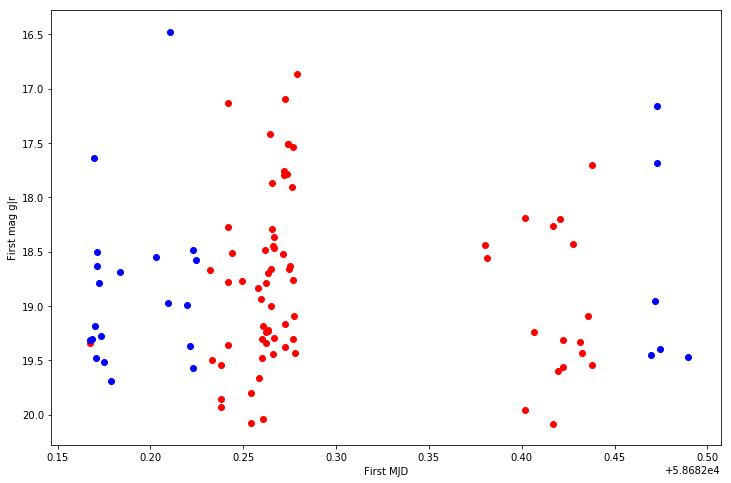

In [8]:
# Show first mag vs first MJD
fig, ax = plt.subplots(figsize = (12, 8))
mask = query_results.first_magpsf_r.notnull()
ax.scatter(query_results.firstmjd[mask], query_results.first_magpsf_r[mask], c = 'r')
mask = query_results.first_magpsf_g.notnull()
ax.scatter(query_results.firstmjd[mask], query_results.first_magpsf_g[mask], c = 'b')
ax.set_xlabel("First MJD")
ax.set_ylabel("First mag g|r")
ax.set_ylim(ax.get_ylim()[::-1])

You can see the ZTF filter changes during the night. The missing times are due to the ZTF private stream.

# 2. get_sql

Get the sql query using the same parameters as the previous query

In [9]:
alerce.get_sql(params)

b"SELECT * FROM objects WHERE  classearly = 'SN' AND  firstmjd >= 58681.58822422096 "

# 3. get_detections

Get all the detections for an object

In [10]:
params = {
    "oid": "ZTF19aaxqsbn"
}

In [11]:
detections = alerce.get_detections(params)
display(detections.head())
list(detections)

,candid_str,dec,diffmaglim,distpsnr1,fid,field,isdiffpos,magap,magap_corr,magnr,...,rb,rcid,sgscore1,sigmadec,sigmagap,sigmagap_corr,sigmagnr,sigmapsf,sigmapsf_corr,sigmara
candid,,,,,,,,,,,,,,,,,,,,,
886240045615015003,886240045615015003,80.162942,20.342619,1.676753,2,862,1,19.145700,19.145700,16.899,...,0.944286,56,0.196298,0.09,0.1670,0.1670,0.073,0.111001,0.111001,0.09
889199085615015000,889199085615015000,80.162995,20.061783,1.792658,1,862,1,19.063999,19.063999,17.948,...,0.750000,56,0.196298,0.09,0.1374,0.1374,0.062,0.153750,0.153750,0.09
889249055615015001,889249055615015001,80.162994,20.234301,1.745674,2,862,1,18.581699,18.581699,16.899,...,0.947143,56,0.196298,0.09,0.1058,0.1058,0.073,0.085079,0.085079,0.09
892240745615015005,892240745615015005,80.162949,19.379860,1.706684,2,862,1,18.940800,18.940800,16.899,...,0.892857,56,0.196298,0.09,0.2974,0.2974,0.073,0.104200,0.104200,0.09
895195845615015003,895195845615015003,80.162940,19.375284,1.912989,1,862,1,18.676800,18.676800,17.948,...,0.951429,56,0.196298,0.09,0.1865,0.1865,0.062,0.112041,0.112041,0.09


['candid_str',
 'dec',
 'diffmaglim',
 'distpsnr1',
 'fid',
 'field',
 'isdiffpos',
 'magap',
 'magap_corr',
 'magnr',
 'magpsf',
 'magpsf_corr',
 'mjd',
 'oid',
 'ra',
 'rb',
 'rcid',
 'sgscore1',
 'sigmadec',
 'sigmagap',
 'sigmagap_corr',
 'sigmagnr',
 'sigmapsf',
 'sigmapsf_corr',
 'sigmara']

# 4. get_non_detections

In [12]:
non_detections = alerce.get_non_detections(params)
non_detections.head()

,diffmaglim,fid,oid
mjd,,,
58617.203958,19.953899,1,ZTF19aaxqsbn
58617.203958,19.953899,1,ZTF19aaxqsbn
58617.203958,19.953899,1,ZTF19aaxqsbn
58617.203958,19.953899,1,ZTF19aaxqsbn
58617.297940,19.972601,2,ZTF19aaxqsbn


(20.753906342183207, 17.976692107523792)

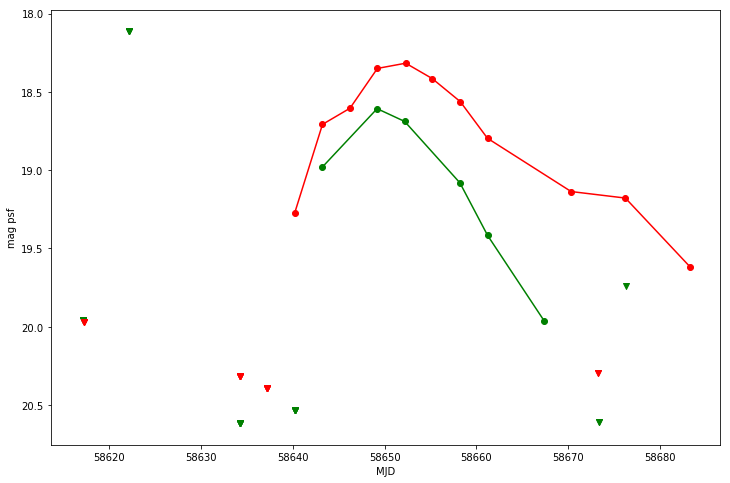

In [13]:
fig, ax = plt.subplots(figsize = (12, 8))
colors = ["g", "r"]
for fid in [1, 2]:
    mask = detections.fid == fid
    ax.plot(detections.mjd[mask], detections.magpsf[mask], c = colors[fid - 1], marker = "o")
    mask = non_detections.fid == fid
    # note that the index of non-detectionsis the mjd
    ax.scatter(non_detections.index[mask], non_detections.diffmaglim[mask], c = colors[fid - 1], marker = "v")
ax.set_xlabel("MJD")
ax.set_ylabel("mag psf")
ax.set_ylim(ax.get_ylim()[::-1])

# 5. get_stats

In [14]:
stats = alerce.get_stats(params)
display(stats)
list(stats)

,classearly,classrf,deltajd,first_magap_g,first_magap_r,first_magpsf_g,first_magpsf_r,firstmjd,last_magap_g,last_magap_r,...,min_magpsf_r,nobs,pclassearly,pclassrf,sigma_magap_g,sigma_magap_r,sigma_magpsf_g,sigma_magpsf_r,sigmadec,sigmara
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aaxqsbn,SN,6,42.973808,19.063999,19.1457,18.982498,19.270462,58640.240046,20.125799,19.399401,...,18.316925,17,0.999165,0.88,0.539562,0.366076,0.502786,0.427516,0.000035,0.000178


['classearly',
 'classrf',
 'deltajd',
 'first_magap_g',
 'first_magap_r',
 'first_magpsf_g',
 'first_magpsf_r',
 'firstmjd',
 'last_magap_g',
 'last_magap_r',
 'last_magpsf_g',
 'last_magpsf_r',
 'lastmjd',
 'max_magap_g',
 'max_magap_r',
 'max_magpsf_g',
 'max_magpsf_r',
 'mean_magap_g',
 'mean_magap_r',
 'mean_magpsf_g',
 'mean_magpsf_r',
 'meandec',
 'meanra',
 'median_magap_g',
 'median_magap_r',
 'median_magpsf_g',
 'median_magpsf_r',
 'min_magap_g',
 'min_magap_r',
 'min_magpsf_g',
 'min_magpsf_r',
 'nobs',
 'pclassearly',
 'pclassrf',
 'sigma_magap_g',
 'sigma_magap_r',
 'sigma_magpsf_g',
 'sigma_magpsf_r',
 'sigmadec',
 'sigmara']

# 6. get_probabilities

In [15]:
early, late = alerce.get_probabilities(params)
display(early)
display(late)

,agn_prob,asteroid_prob,bogus_prob,sn_prob,vs_prob
oid,,,,,
ZTF19aaxqsbn,0.000005,5.469358e-09,0.000829,0.999165,4.666816e-10


,ceph_prob,classifierid,dsct_prob,eb_prob,lpv_prob,other_prob,rrl_prob,sne_prob
oid,,,,,,,,
ZTF19aaxqsbn,0.002,1,0.0,0.012,0.012,0.09,0.004,0.88


# 7. get_features

In [16]:
features = alerce.get_features(params)
features

,result.period.n_samples_1,result.period.n_samples_2,result.period.periodls_1,result.period.periodls_2
oid,,,,
ZTF19aaxqsbn,6.0,11.0,0.589657,0.589657


# 8. get_stamp

Get the stamps of an object.

See https://github.com/alercebroker/usecases/blob/master/api/ALeRCE%20AVRO-STAMP%20Access%20API.md

In [19]:
# note that the index of detections is the candid
print(params["oid"])
alerce.plotstamp(params["oid"], detections.index.min())
alerce.plotstamp(params["oid"], detections.index.max())

ZTF19aaxqsbn
